<a href="https://colab.research.google.com/github/KulluMahi/Projects/blob/master/Housing_price_regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import tarfile
import urllib
DOWNLOAD_ROOT ="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH =os.path.join('datasets','housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  os.makedirs(housing_path,exist_ok=True)
  tgz_path =os.path.join(housing_path,'housing.tgz')
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz =tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
# load the training dataset
import pandas as pd
def housing_data(housing_path=HOUSING_PATH):
  housing_loc = os.path.join(housing_path,'housing.csv')
  return pd.read_csv(housing_loc)


In [4]:
# read the data and look into head of data
housing = housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info() # info gives the details of no of rows and columns and type of columns as well as non null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts() # count of each category of categorical variable

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe() # describe the descriptive statistics of numerical variable

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f884ec7f4a8>,
      dtype=object)

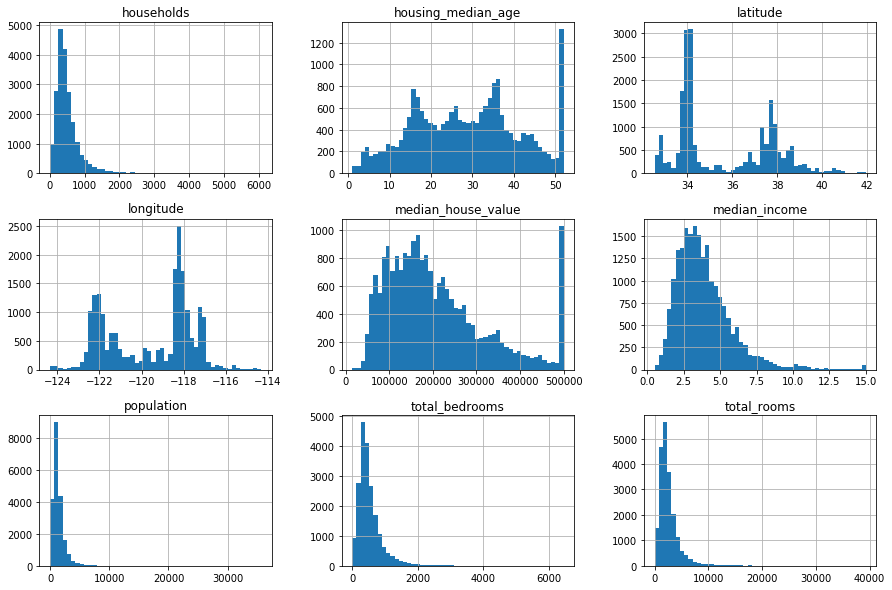

In [8]:
# look into the data
import matplotlib.pyplot as plt
%matplotlib inline
housing.hist(bins=50,figsize=(15,10))

In [0]:
# before we deep dig into dataset we create the test set and keep aside
import numpy as np
def split_train_test(data,test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_ids = shuffled_indices[:test_set_size]
  train_ids = shuffled_indices[test_set_size:]
  return data.iloc[train_ids] , data.iloc[test_ids]

In [10]:
train_set , test_set = split_train_test(housing,0.2)
display(train_set.shape , test_set.shape)

(16512, 10)

(4128, 10)

In [0]:
# problem with this method is that when we run the function again , test set value will change in every run , every value will be seen by system
# which is don't want to see the system whole dataset to avoid this either save the test set in file and load the file in subsequent run , one more mehtod is that 
# use the random seed of numpy but both solution will break when we load the updated dataset for this purpose we use the instance identifier which is 
# unique and hashable
import numpy as np
def split_train_test(data,test_ratio):
  np.random.seed(42)
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_ids = shuffled_indices[:test_set_size]
  train_ids = shuffled_indices[test_set_size:]
  return data.iloc[train_ids] , data.iloc[test_ids]

In [0]:
# split the dataset based on ids or instance identifier
from zlib import crc32
def test_set_check(identifier ,test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def train_test_split_id(data,test_ratio,column_id):
  ids = data[column_id]
  in_test_set = ids.apply(lambda id_ : test_set_check(id_,test_ratio))
  return data.loc[~in_test_set] , data.loc[in_test_set]

In [0]:
# but in this we don't have instance identifier hence we use the column index
housing_id = housing.reset_index()
train_set_id , test_set_id = train_test_split_id(housing_id,0.2,'index')

In [14]:
display(train_set_id.shape)
display(test_set_id.shape)

(16512, 11)

(4128, 11)

In [0]:
# we need to ensure that data should be equally distributed among all the category 
housing['income_cat'] = pd.cut(housing['median_income'] ,
                               bins=(0,1.5,3,4.5,6,np.inf),
                               labels=(1,2,3,4,5))

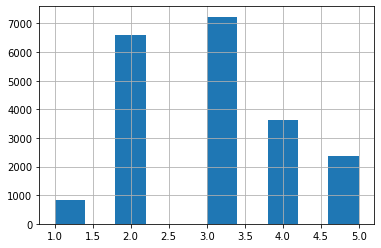

In [16]:
housing['income_cat'].hist()


In [0]:
# now do the stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_ix, test_ix in split.split(housing,housing['income_cat']):
  strat_train_set = housing.iloc[train_ix]
  strat_test_set = housing.iloc[test_ix]

In [18]:
# now check the sampling ratio
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [20]:
# now remove the extra  added variable
strat_train_set.drop('income_cat',axis=1,inplace=True)
strat_test_set.drop('income_cat',axis=1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
# if there is some geographical then have look at it
housing=strat_train_set.copy()


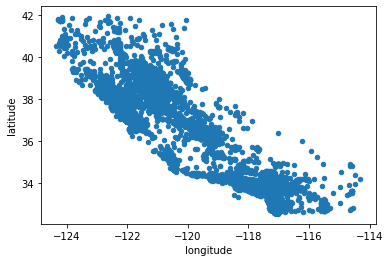

In [26]:
housing.plot(kind='scatter',x='longitude',y='latitude')

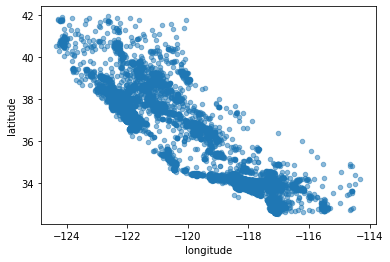

In [27]:
# we use  alpha to get the dense area of city
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.5)

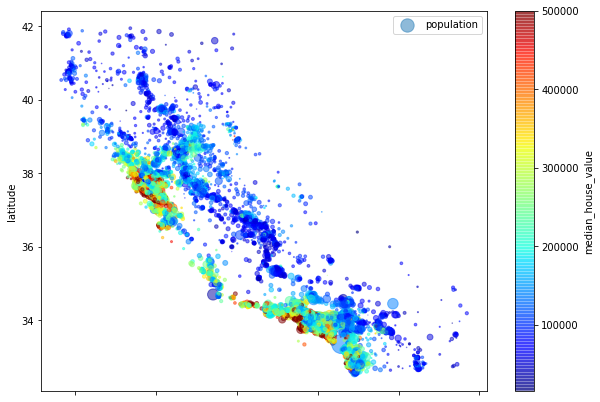

In [28]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.5,s=housing['population']/100 ,label="population",
c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,figsize=(10,7))
plt.legend()



In [0]:
# now check for correlation
corr_matrix = housing.corr()

In [30]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f883aaac710>,
      dtype=object)

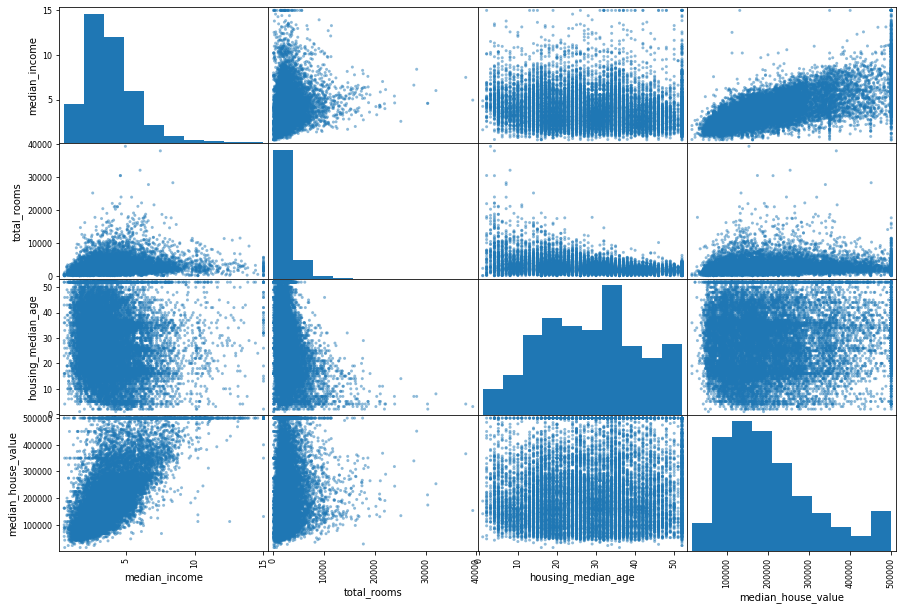

In [31]:
# we can also use the pandas scatter matrix function
from pandas.plotting import scatter_matrix
features =['median_income','total_rooms','housing_median_age','median_house_value']
scatter_matrix(housing[features],figsize=(15,10))

In [32]:
# if we check the correlation between variable
corr_matrix[corr_matrix>0.5 ] 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing_median_age,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,1.000000,0.929379,0.855109,0.918392,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.929379,1.000000,0.876320,0.980170,NaN,NaN
population,NaN,NaN,NaN,0.855109,0.876320,1.000000,0.904637,NaN,NaN
households,NaN,NaN,NaN,0.918392,0.980170,0.904637,1.000000,NaN,NaN
median_income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.68716
median_house_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.68716,1.00000


In [0]:
# add more attribute in dataset
housing['population_per_house'] =housing['population']/housing['households']
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

In [0]:
corr_matrix=housing.corr()

In [35]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687160
rooms_per_household     0.146285
total_rooms             0.135097
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
population_per_house   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
bedrooms_per_room      -0.259984
Name: median_house_value, dtype: float64

In [0]:
# Prepare the data for machine learning
housing = strat_train_set.drop('median_house_value',axis=1).copy()
housing_label = strat_train_set[['median_house_value']]

In [89]:
# handle the missing value 3 possible values 1.either drop the column , 2.drop null value 3. fill with null values
# we use the last 
housing_num=housing.drop('ocean_proximity',axis=1)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [90]:
# it value in 
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [91]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [0]:
X= imputer.transform(housing_num)

In [93]:
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [0]:
# now to handle the categorical variable
# as we know there is only one categorical variable 
housing_cat = housing[['ocean_proximity']]

In [0]:
from sklearn.preprocessing import OrdinalEncoder

In [96]:
cat_encoder = OrdinalEncoder()
cat_encoder.fit(housing_cat)

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [97]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [0]:
housing_cat=cat_encoder.transform(housing_cat)

In [99]:
housing_cat[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [100]:
# problem with this is it consider two near by value similar to overcome this problem we use Onehotenconder , it store value of non zero value and return 
# sparse matrix
from sklearn.preprocessing import OneHotEncoder
onehotecoder = OneHotEncoder()
housing_cat=onehotecoder.fit_transform(housing_cat)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [101]:
housing_cat.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [0]:
# custrom transformer
from sklearn.base import BaseEstimator , TransformerMixin
room_ix,bedroom_ix,population_ix,household_ix=3,4,5,6
class AddAttribute(BaseEstimator,TransformerMixin):
  def __init__(self,add_bedroom_per_room=True):
    self.add_bedroom_per_room = add_bedroom_per_room
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    room_per_household= X[:,room_ix]/X[:,household_ix]
    population_per_household =X[:,population_ix]/X[:,household_ix]
    if self.add_bedroom_per_room:
      bedroom_per_room = X[:,bedroom_ix]/X[:,room_ix]
      return np.c_[X,room_per_household,population_per_household,bedroom_per_room]
    else:
      return np.c_[X,room_per_household,population_per_household]


In [0]:
addatribute = AddAttribute(add_bedroom_per_room=False)


In [0]:
Housing_extra_attribute=addatribute.fit_transform(housing.values)

In [105]:
Housing_extra_attribute

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [0]:
# Feature Scaling 
# min-max scalar
# standard scaler
# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
num_pipe = Pipeline([('imputer',SimpleImputer(strategy='median')),
                     ('attr_adder',AddAttribute()),
                     ('stndr_sclr',StandardScaler())])
housing_attribue = num_pipe.fit_transform(housing_num)


In [107]:
housing_attribue

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [0]:
from sklearn.compose import ColumnTransformer
num = list(housing_num)
cat = ['ocean_proximity']
full_pipeline = ColumnTransformer([('num',num_pipe,num),
                                   ('cat',OneHotEncoder(),cat)])

In [0]:
housing_prepared = full_pipeline.fit_transform(housing)

In [110]:
# now select and train the model
# first we use Linear Regression
from sklearn.linear_model import LinearRegression
Lin_Reg = LinearRegression()
Lin_Reg.fit(housing_prepared,housing_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
# now transform the model and and calculate the rmse
from sklearn.metrics import mean_squared_error
Lin_predict = Lin_Reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label,Lin_predict)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68628.19819848923

In [114]:
# we will try the decision tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(housing_prepared,housing_label)
dt_predict = dt.predict(housing_prepared)
dt_mse = mean_squared_error(housing_label,dt_predict)
dt_rmse = np.sqrt(dt_mse)
dt_rmse

0.0

In [0]:
# BETTER EVALUATION USING CROSS VALIDATION
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
tree_rmse_score = np.sqrt(-scores)

In [0]:
def display_score(scores):
  print('scores' ,scores)
  print('mean',scores.mean())
  print('std',scores.std())


In [118]:
display_score(tree_rmse_score)

scores [69945.56005109 66221.27797547 70436.0465542  69479.0105491
 71092.8447054  74246.05603986 70441.61758584 69563.95879225
 75904.33943648 69715.60315484]
mean 70704.63148445141
std 2536.3118968445997


In [120]:
# now cross_validate the linear regression model using cross val score
lin_score = cross_val_score(Lin_Reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
lin_rmse_score = np.sqrt(-lin_score)
display_score(lin_rmse_score)

scores [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean 69052.46136345083
std 2731.674001798344


In [126]:
# now train the another one model
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared,housing_label)
rf_predict = rf_reg.predict(housing_prepared)
rf_mse  = mean_squared_error(housing_label,rf_predict)
rf_rmse = np.sqrt(rf_mse)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
rf_rmse

22165.5407186105

In [132]:
housing_label = strat_train_set['median_house_value'].copy()
rf_score = cross_val_score(rf_reg , housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
rf_rmse_score = np.sqrt(-rf_score)
display_score(rf_rmse_score)

scores [52402.54083669 51017.29120818 52268.20942935 55295.54233586
 52271.95219332 55373.01153305 52501.841458   49953.25496079
 55504.9642975  52097.57473475]
mean 52868.61829874907
std 1808.3634659151887


In [133]:
# fine tune your model using grid cv search method
from sklearn.model_selection import GridSearchCV
param_grid=[{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
            {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]
random_forest = RandomForestRegressor()
grid_search_cv = GridSearchCV(random_forest,param_grid,refit=True,scoring='neg_mean_squared_error',cv=5,return_train_score=True)
grid_search_cv.fit(housing_prepared,housing_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [134]:
grid_search_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [137]:
cvres = grid_search_cv.cv_results_
for mean_score , params in zip(cvres['mean_test_score'],cvres['params']):
  print(np.sqrt(-mean_score),params)

64831.50361959459 {'max_features': 2, 'n_estimators': 3}
55579.65643394557 {'max_features': 2, 'n_estimators': 10}
53085.13270773533 {'max_features': 2, 'n_estimators': 30}
60903.9806655294 {'max_features': 4, 'n_estimators': 3}
53048.96937423525 {'max_features': 4, 'n_estimators': 10}
50497.82569616765 {'max_features': 4, 'n_estimators': 30}
59042.251733183395 {'max_features': 6, 'n_estimators': 3}
52149.25211181676 {'max_features': 6, 'n_estimators': 10}
50120.302476464516 {'max_features': 6, 'n_estimators': 30}
58829.8518591428 {'max_features': 8, 'n_estimators': 3}
52209.26395651133 {'max_features': 8, 'n_estimators': 10}
49813.92740666187 {'max_features': 8, 'n_estimators': 30}
62347.619616966695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53832.907939286786 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59714.49596311453 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52286.89768221354 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [0]:
# evaluate the model on test set 
final_model = grid_search_cv.best_estimator_
X_test = strat_test_set.drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [0]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)

In [140]:
final_rmse

48098.99780368389

In [142]:
# to check how confident we are
from scipy import stats
confidence=0.95
squared_errors = (final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46052.98743685, 50061.45750554])